<center><h1>QBUS6860 - Visual Data Analytics</h1></center>

# Tutorial 11 - Clustering

## Learning objectives and tasks:

Today we will work on a customer segmentation excercise. We will go through the following steps:
* Step 1: Loading necessary libraries and the dataset
* Step 2: Data pre-processing for K-Means Clustering.
* Step 3: EDA and Visualizations of the dataset.
* Step 4: Building a K-Means Clustering model from scratch.
* Step 5: Visualization, interpretation, and analysis of the obtained clusters
* Step 6: Introduction to stacking models: building a machine learning pipeline

### Step 1: Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data=pd.read_csv(r'/Users/leesi/usyd/qbus6860/data/customerdata.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [3]:
data.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

We have 4 variables which can help us cluster customers:

* one categorical variable - gender
* three numerical variables - age, income, spending score

In [4]:
data.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

#### 1.1 Assign index to dataframe

We need to create an index variable to work with the data. For this, we assign ‘CustomerID’ as the index as it is the unique identifier for each customer.

In [5]:
data = pd.read_csv(r'/Users/leesi/usyd/qbus6860/data/customerdata.csv', index_col="CustomerID")
data.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1             Male   19                  15                      39
2             Male   21                  15                      81
3           Female   20                  16                       6
4           Female   23                  16                      77
5           Female   31                  17                      40

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


### Step 2: Data pre-processing for K-Means Clustering

#### 2.1 Inspect outliers

The first thing we need to do is consider outliers and get rid of them if necessary.  Recall how we did this when we ran EDAs in previous weeks in this unit

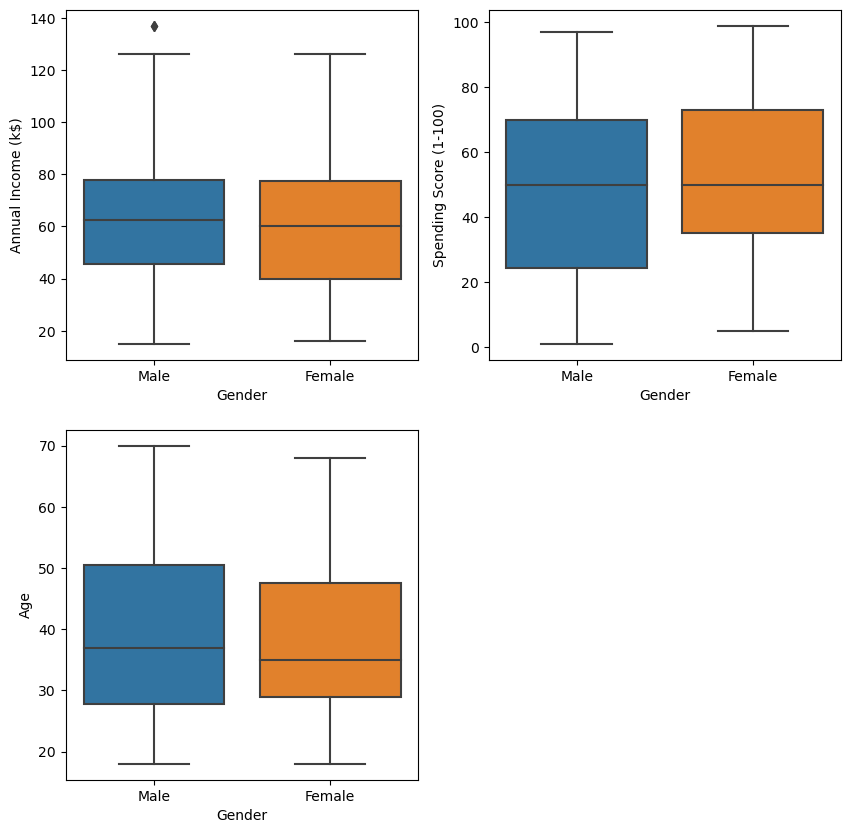

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
  
def graph(y):
    sns.boxplot(x="Gender", y=y, data=data)

plt.figure(figsize=(10,10))

# Adding the subplot at the specified
# grid position
plt.subplot(221)
graph('Annual Income (k$)')
  
plt.subplot(222)
graph('Spending Score (1-100)')
  
plt.subplot(223)
graph('Age')
    
plt.show()

There seems to be some outliers in the Income variable (for male customers) let's look at this variable separately and for all customers (male+female)

Text(0.5, 1.0, 'Boxplot of Annual Income for All Customers')

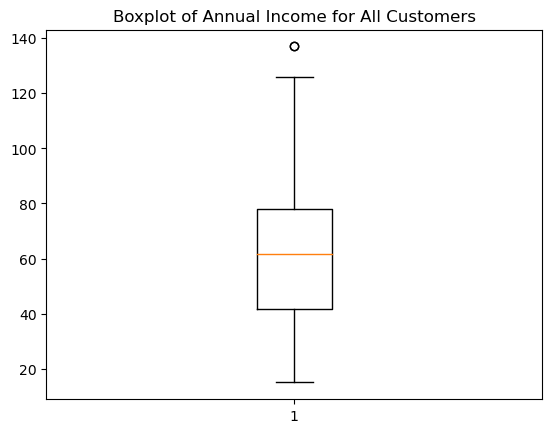

In [8]:
plt.boxplot(data['Annual Income (k$)'])
plt.title('Boxplot of Annual Income for All Customers')

#### 2.2 Replace outliers

Let's handle these outliers using the interquartile range method. We have done this before when we have done EDAs

In [9]:
Q1=np.percentile(data['Annual Income (k$)'],25,interpolation='midpoint')
Q2=np.percentile(data['Annual Income (k$)'],50,interpolation='midpoint')
Q3=np.percentile(data['Annual Income (k$)'],75,interpolation='midpoint')
IQR=Q3-Q1
lower_limit=Q1-1.5*IQR
upper_limit=Q3+1.5*IQR
outlier=[]

for x in data['Annual Income (k$)']:
    if((x>upper_limit)or(x<lower_limit)):
        outlier.append(x)

We found 2 outliers at the level of $137k. We will now find the respective indices and drop the entire two rows from the analysis.

In [10]:
outlier_index=data['Annual Income (k$)']>upper_limit
data.loc[outlier_index].index

Int64Index([199, 200], dtype='int64', name='CustomerID')

Records 199 and 200 are above our calculated "upper limit". We will drop records 199 and 200 now

In [11]:
data.drop([199, 200],inplace=True)

### Step 3: EDA and Visualizations of the dataset

We have done this before. For the purposes of this tutorial, we will not go through all stages of EDA.

We will run a simplified version of EDA running through the steps, which will help us do the clustering.

Let's see how many males and females we have in the dataset

#### 3.1 Univariate EDA - Categorical variable - Gender

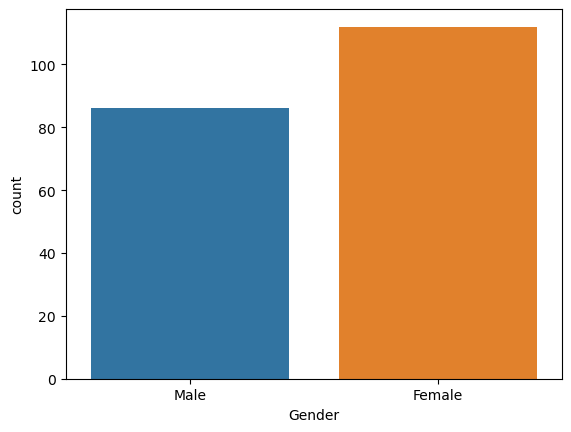

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Gender', data=data)
plt.show()

In [13]:
data.value_counts("Gender")

Gender
Female    112
Male       86
dtype: int64

So we've got 112 females and 86 males in our customer dataset

Now let's look at the distribution of age, income, and spending score  using histograms overlaid with density plot


#### 3.2 Univariate EDA - Numerical variables - Age, Annual Income, Spending Score

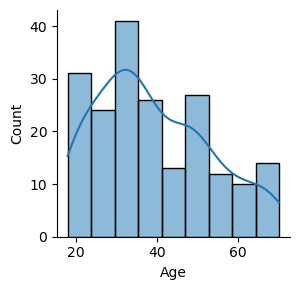

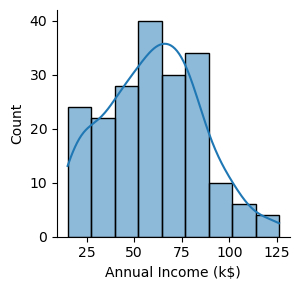

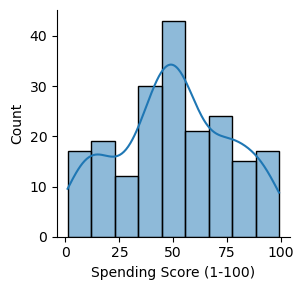

In [14]:
#Now let's look at the distribution of age, income, and spending score 
#using histograms overlaid with density plot
plot = sns.FacetGrid(data)
plot.map(sns.histplot, "Age", kde=True).add_legend()
  
plot = sns.FacetGrid(data)
plot.map(sns.histplot, "Annual Income (k$)", kde=True).add_legend()
  
plot = sns.FacetGrid(data)
plot.map(sns.histplot, "Spending Score (1-100)", kde=True).add_legend()

plt.show()

#### 3.3 Combining categorical and numerical variables

Let's see what the same historgams look like if clustered by gender:

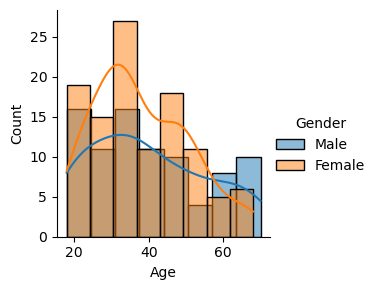

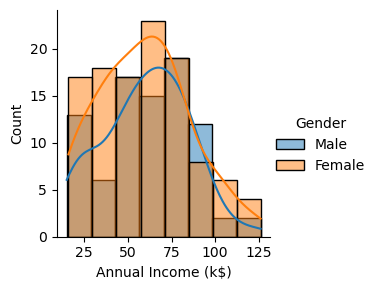

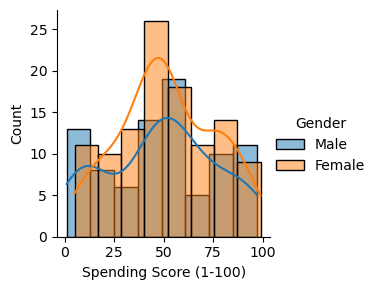

In [15]:
plot = sns.FacetGrid(data,hue="Gender")
plot.map(sns.histplot, "Age", kde=True).add_legend()
  
plot = sns.FacetGrid(data, hue="Gender")
plot.map(sns.histplot, "Annual Income (k$)", kde=True).add_legend()
  
plot = sns.FacetGrid(data, hue="Gender")
plot.map(sns.histplot, "Spending Score (1-100)", kde=True).add_legend()
  
plt.show()

In all cases, the data seems to be more or less 'beta-normally distributed'. The KDE on the distribution plots look like a bell curves. 

#### 3.4 Data preparation for bivariate EDA

Usually at this stage of EDA we do the bivariate analysis. But we have a problem: gender is categorical. We need to first convert it to numerical. Also, EDA is not the purpose of our excercise, so we will jump straight into the pairplot to save time.

In [16]:
gender= {'Male':0, 'Female':1}
data['Gender']= data['Gender'].map(gender)

In [17]:
#let's check what we've got now
print(data)

            Gender  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1                0   19                  15                      39
2                0   21                  15                      81
3                1   20                  16                       6
4                1   23                  16                      77
5                1   31                  17                      40
...            ...  ...                 ...                     ...
194              1   38                 113                      91
195              1   47                 120                      16
196              1   35                 120                      79
197              1   45                 126                      28
198              0   32                 126                      74

[198 rows x 4 columns]


Gender is now numerical. We can go ahead and use it in our segmentation analysis. To save time, we can jump straight into the multivariate analysis and look at the pairplot

#### 3.5. Bivariate EDA 1

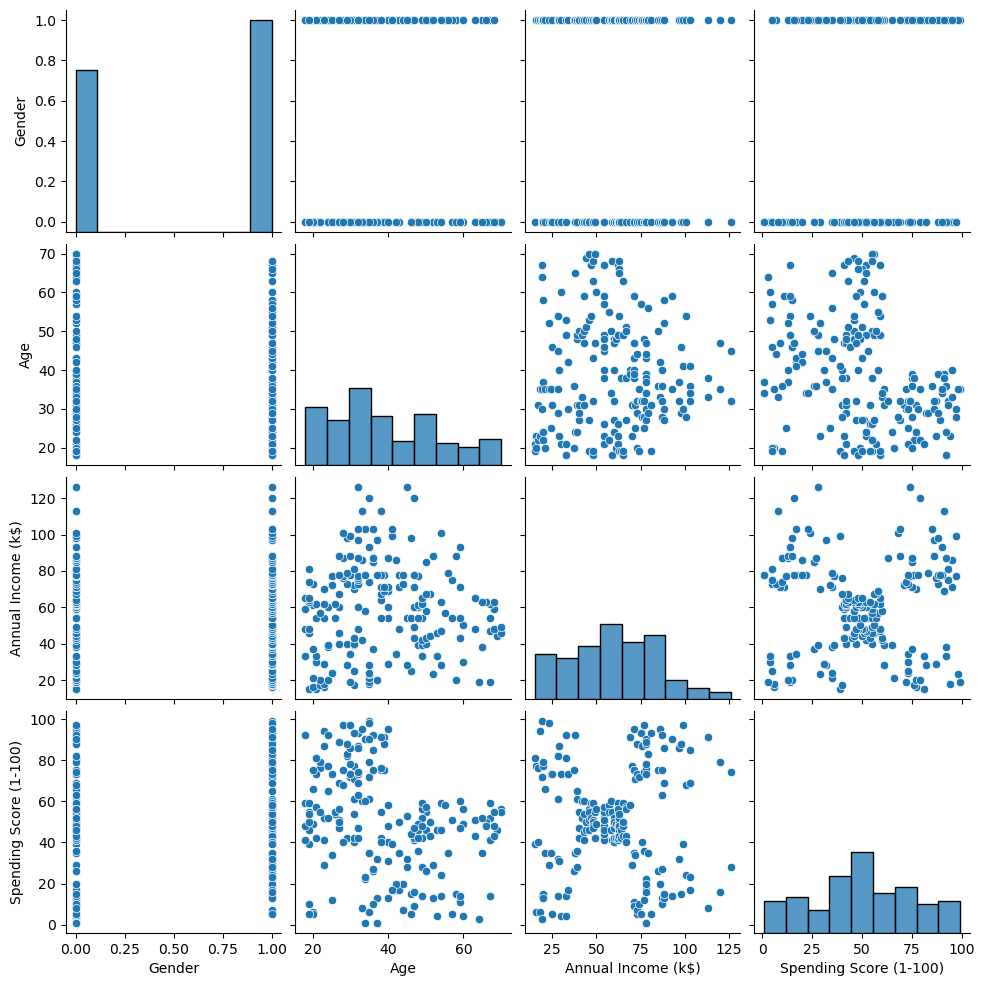

In [18]:
sns.pairplot(data)

#### 3.6. Bivariate EDA 2

This gives us an overview of each bivariate comparison. We can also now run the same pairplot using Gender as a "hue" variable

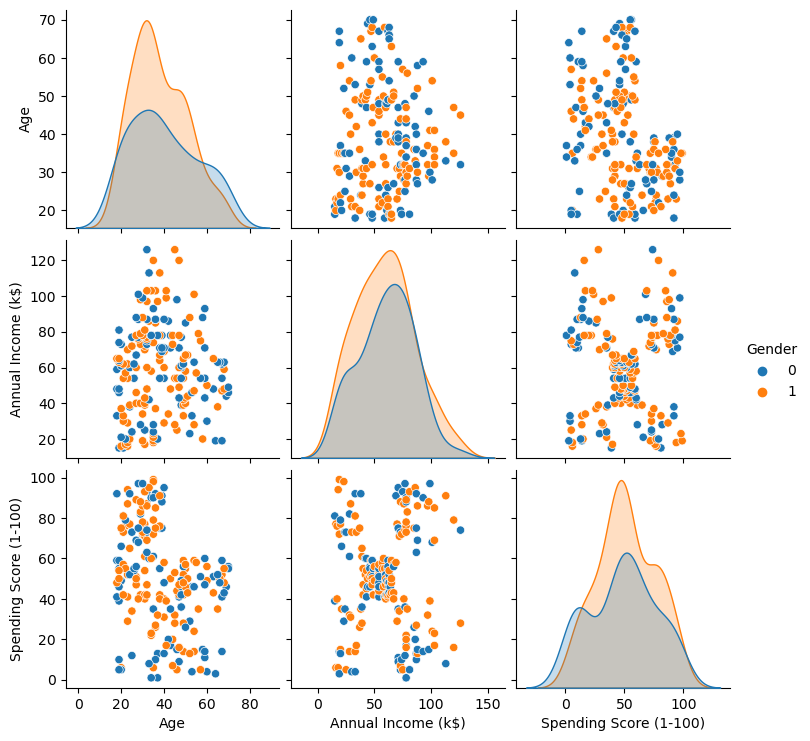

In [19]:
sns.pairplot(data, hue = 'Gender')

What insights do we derive from these plots?
1. the lower the age higher the spending score;
2. customers between 30–50 years of age have the highest annual income;
3. annual income of $40–70k corresponds to a 40–60 spending score (roughly speaking);
4. women tend to spend marginally more than men;
5. there is not much difference in the annual income between men and women (after we have removed the outliers);
6. some males in the dataset are older than the females (female customer base is marginally younger)

Now let's do a full-scale multivariate analysis using heatmap

<AxesSubplot:>

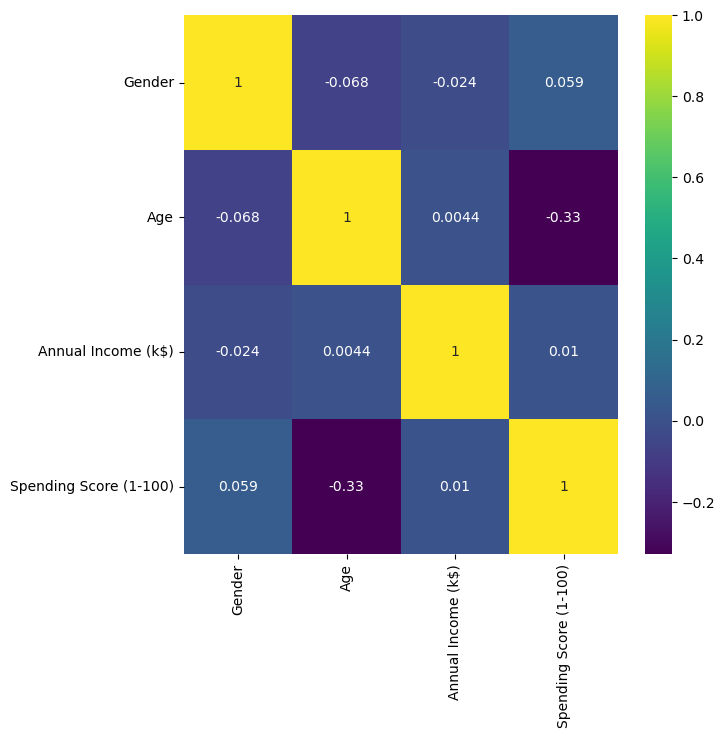

In [20]:
fig_dims = (7, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(data.corr(), annot=True, cmap='viridis')

What insights do we derive from the heatmap?

1. Age is negatively correlated with spending
2. Income is positively correlated with age, but the relationship is weak
3. Income and spending are also directly related but the relationship is weak
4. Gender is directly related to spending, but inversely related to income

### Step 4: Building a K-Means Clustering model from scratch.

#### 4.1 Data preparation: scaling of variables

Now we will build our model, but first we need to Standardize our variables. We need to get all variables to be on the same scale

In [21]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
data.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1                0   19                  15                      39
2                0   21                  15                      81
3                1   20                  16                       6
4                1   23                  16                      77
5                1   31                  17                      40

In case you are wondering what exactly do scaled data look like you can print it. This substep is optional

In [22]:
print(scaled_data)

[[-1.42541358 -1.77917141 -0.43598941]
 [-1.2823665  -1.77917141  1.19941337]
 [-1.35389004 -1.73944701 -1.72094874]
 [-1.13931942 -1.73944701  1.04366072]
 [-0.5671311  -1.69972262 -0.39705125]
 [-1.21084296 -1.69972262  1.00472256]
 [-0.28103694 -1.65999822 -1.72094874]
 [-1.13931942 -1.65999822  1.70560947]
 [ 1.79314572 -1.62027383 -1.83776323]
 [-0.63865464 -1.62027383  0.84896992]
 [ 2.00771635 -1.62027383 -1.40944345]
 [-0.28103694 -1.62027383  1.90030028]
 [ 1.36400448 -1.58054943 -1.37050529]
 [-1.06779588 -1.58054943  1.04366072]
 [-0.13798986 -1.58054943 -1.44838161]
 [-1.21084296 -1.58054943  1.12153705]
 [-0.28103694 -1.54082504 -0.59174206]
 [-1.35389004 -1.54082504  0.61534095]
 [ 0.93486324 -1.46137625 -0.82537103]
 [-0.28103694 -1.46137625  1.86136212]
 [-0.28103694 -1.42165185 -0.59174206]
 [-0.99627234 -1.42165185  0.88790808]
 [ 0.505722   -1.38192745 -1.75988691]
 [-0.5671311  -1.38192745  0.88790808]
 [ 1.07791032 -1.26275427 -1.40944345]
 [-0.71017818 -1.26275427

#### 4.2 Build initial model

Text(0, 0.5, 'Spending Score (1-100)')

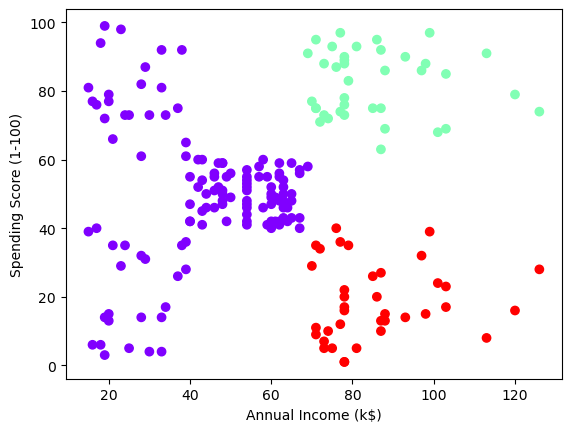

In [23]:
# Now we can run our model
# create a copy of the data variable
x = data.copy()

# The number in the brackets is K, 
# K represents the number of clusters we are aiming for
# here we take 3 arbitrarily
kmeans = KMeans(3)

# Fit the data
kmeans.fit(x)

# Create a copy of the input data
clusters = x.copy()

# Take note of the predicted clusters 
clusters['cluster_pred']=kmeans.fit_predict(x)

# Plot the data using the Annual Income and the Spending Score variables
plt.scatter(clusters['Annual Income (k$)'],
            clusters['Spending Score (1-100)'],
            c=clusters['cluster_pred'],
            cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

In [24]:
x

Gender  Age  Annual Income (k$)  Spending Score (1-100)
CustomerID                                                         
1                0   19                  15                      39
2                0   21                  15                      81
3                1   20                  16                       6
4                1   23                  16                      77
5                1   31                  17                      40
...            ...  ...                 ...                     ...
194              1   38                 113                      91
195              1   47                 120                      16
196              1   35                 120                      79
197              1   45                 126                      28
198              0   32                 126                      74

[198 rows x 4 columns]

#### 4.3 Refine initial model by finding the optimal number of clusters

This scatterplot suggests that we might have 3 clusters. It may or may not be correct (remember, we forced the model to find 3 clusters). To figure this out, we apply the Elbow Method. This method allows us to find the most appropriate number of clusters (optimal ‘K’) through the sum of distances of observations from their cluster centroids, called Within-Cluster-Sum-of-Squares (WCSS)

C:\Users\leesi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'within Clusters Sum of Squares(WCSS)')

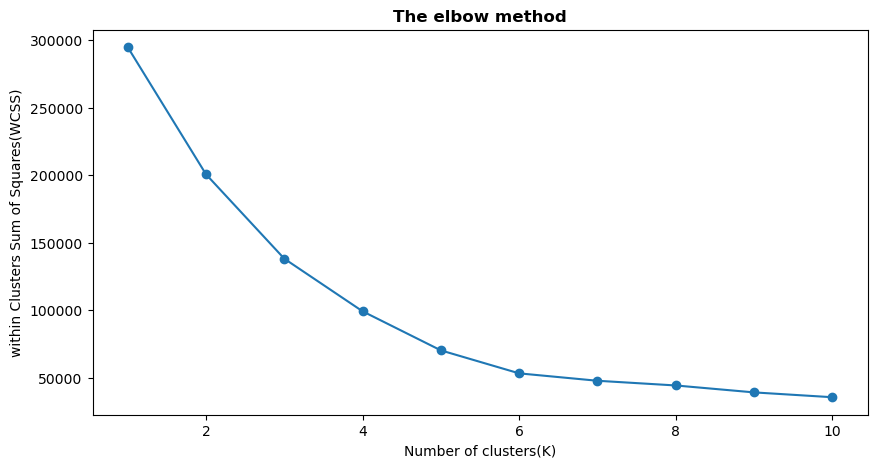

In [25]:
wcss=[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', 
                    max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(x)
    wcss_iter=kmeans.inertia_
    wcss.append(wcss_iter)

# Now we need to generate a line graph which will help us find 'The Elbow'
# or the optimal number of clusters (K)
plt.figure(figsize=(10,5))
no_clusters=range(1,11)
plt.plot(no_clusters, wcss,marker = "o")
plt.title('The elbow method', fontweight="bold")
plt.xlabel('Number of clusters(K)')
plt.ylabel('within Clusters Sum of Squares(WCSS)')

#### How do we read these results?

We need to look for the point after which the WCSS line stops to decrease drastically in the above graph, it is 5. The line only very slightly drops between 6 and 10. So, we should have 5 clusters. Let's generate 5 clusters and plot our results.

At this point, we need to calculate the "silhouette score". It is a metric used to measure how dense and well separated the clusters are. The score ranges from -1 to 1. The higher is the silhouette score, the better is the model as the score measures the distance between a particular data point and all data points in the nearest cluster. It is basically the "Euclidian" distance score.

In [26]:
print(silhouette_score(clusters, kmeans.labels_, metric='euclidean'))

0.37084007427621946


#### How do we read this score?

The silhouette score of 1 means that the clusters are very dense and nicely separated. The score of 0 means that clusters are overlapping. The score of less than 0 means that data belonging to clusters may be wrong/incorrect. So, 0.37 is an acceptable score - we can go ahead and plot our 5 customer segments.

#### 4.4 Build model with optimal number of clusters

We assign the optimal number of clusters to 5, create a new data frame with the predicted clusters, and return Gender to categorical type.

In [27]:
kmeans_new = KMeans(5, random_state=0)

# Fit the data
kmeans_new.fit(x)

# Create a new data frame with the predicted clusters
clusters_new = x.copy()
clusters_new['cluster_pred'] = kmeans_new.fit_predict(x)

# Recategorising Gender variable back to 'male' and 'female'
gender= {0:'Male',1:'Female'}
clusters_new['Gender']= clusters_new['Gender'].map(gender)

In [28]:
#Let's see what we've got now
print(clusters_new)

            Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
CustomerID                                                            
1             Male   19                  15                      39   
2             Male   21                  15                      81   
3           Female   20                  16                       6   
4           Female   23                  16                      77   
5           Female   31                  17                      40   
...            ...  ...                 ...                     ...   
194         Female   38                 113                      91   
195         Female   47                 120                      16   
196         Female   35                 120                      79   
197         Female   45                 126                      28   
198           Male   32                 126                      74   

            cluster_pred  
CustomerID                
1                     

In [29]:
# Keeping a copy of clusters_new for further manipulation in preparation of a clustermap
clusters_df = clusters_new
clusters_df.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
CustomerID                                                            
1             Male   19                  15                      39   
2             Male   21                  15                      81   
3           Female   20                  16                       6   
4           Female   23                  16                      77   
5           Female   31                  17                      40   

            cluster_pred  
CustomerID                
1                      0  
2                      3  
3                      0  
4                      3  
5                      0

#### 4.5 Inspect clustering results

As you can see, now the data frame contains predicted clusters. Let's go ahead and plot them

Text(0, 0.5, 'Spending Score (1-100)')

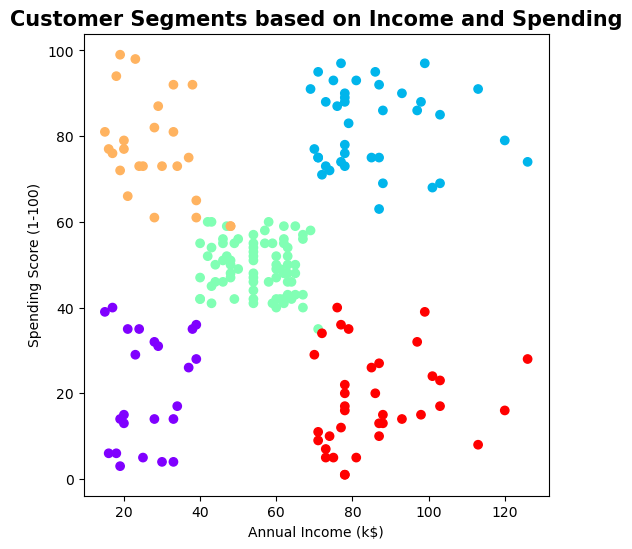

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(clusters_new['Annual Income (k$)'],
            clusters_new['Spending Score (1-100)'],
            c=clusters_new['cluster_pred'],
            cmap='rainbow')
plt.title("Customer Segments based on Income and Spending", fontsize=15,fontweight="bold")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")

Let's map these clusters by income and spending.

In [31]:
avg_data = clusters_new.groupby(['cluster_pred'], as_index=False).mean()
avg_data

cluster_pred        Age  Annual Income (k$)  Spending Score (1-100)
0             0  45.217391           26.304348               20.913043
1             1  32.763158           85.210526               82.105263
2             2  43.934211           55.210526               49.447368
3             3  24.960000           28.040000               77.000000
4             4  40.555556           86.055556               18.194444

#### 4.6 Assigning meaningful descriptions and colors to clusters

To make sure that we do not get lost in segments. Let's assign "permanent" descriptions to our groups. Otherwise, we will struggle to describe our results. At the moment, colors and cluster_cred values do not mean anything

We want to have:

* low annual income, low spending score segment = 'Low-Income Careful'
* low annual income, high spending score segment = 'Low-Income Careless'
* medium annual income, medium spending score segment = 'Mid-Income Calibrated'
* high annual income, high spending score segment = 'High Income Highly Engaged'
* high annual income, low spending score segment = 'High Income Disengaged'

In [32]:
# let's create a new data frame to work with
segments=clusters_new
print(segments)

            Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
CustomerID                                                            
1             Male   19                  15                      39   
2             Male   21                  15                      81   
3           Female   20                  16                       6   
4           Female   23                  16                      77   
5           Female   31                  17                      40   
...            ...  ...                 ...                     ...   
194         Female   38                 113                      91   
195         Female   47                 120                      16   
196         Female   35                 120                      79   
197         Female   45                 126                      28   
198           Male   32                 126                      74   

            cluster_pred  
CustomerID                
1                     

Now we need make our numerical variable  cluster_pred categorical

IMPORTANT: every time you run k-means clustering your cluster_pred values will correspond to different clusters. So, at this step, be very very careful when you assign permanent categories instead of numerical values.

Make sure you get it right carefully look into the table with average income and spending per group
and make correct assignment

For me at the moment, the following is true (for you it might be different - please, carefully check you averages table):

* low annual income, low spending score segment = 'Low-Income Careful'=cluster_pred=0
* low annual income, high spending score segment = 'Low-Income Careless'=cluster_pred=3
* medium annual income, medium spending score segment = 'Mid-Income Calibrated' = cluster_pred=2
* high annual income, high spending score segment = 'High Income Highly Engaged'=cluster_pred=1
* high annual income, low spending score segment = 'High Income Disengaged'=cluster_pred=4

For you this correspondence is likely to be different

BE VERY CAREFUL HERE. MAKE SURE YOU ASSIGN CUSTOMER SEGEMENT IN <code>cluster_pred</code> CATEGORIES CORRECTLY.

Let's recategorise our cluster_pred into a categorical variable

In [33]:
# Let's recategorise our cluster_pred into a categorical variable
cseg= {1:'High Income Highly Engaged',
               2:'Mid-Income Calibrated', 
               3:'Low-Income Careless',
               0:'Low-Income Careful',
               4:'High Income Disengaged'}
segments['cluster_pred']= segments['cluster_pred'].map(cseg)

print(segments)

            Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
CustomerID                                                            
1             Male   19                  15                      39   
2             Male   21                  15                      81   
3           Female   20                  16                       6   
4           Female   23                  16                      77   
5           Female   31                  17                      40   
...            ...  ...                 ...                     ...   
194         Female   38                 113                      91   
195         Female   47                 120                      16   
196         Female   35                 120                      79   
197         Female   45                 126                      28   
198           Male   32                 126                      74   

                          cluster_pred  
CustomerID                         

Now we also want to assign "permanent" colors to my segments

* Red segment: low annual income, low spending score = "Low-Income Careful"
* Orange segment: low annual income, high spending score = "Low-Income Careless"
* Blue segment: medium annual income, medium spending score = "Mid-Income Calibrated"
* Purple segment: high annual income, high spending score = "High Income Engaged"
* Green segment: high annual income, low spending score = "High Income Disengaged"

In [34]:
import plotly.express as px

fig = px.scatter(segments, 
                 x='Annual Income (k$)',
                 y='Spending Score (1-100)',
                 color='cluster_pred', 
                 color_discrete_map={'High Income Highly Engaged': 'purple', 
                                     'Mid-Income Calibrated': 'blue', 
                                     'Low-Income Careless': 'orange', 
                                     'Low-Income Careful': 'red', 
                                     'High Income Disengaged': 'green'})
fig.show()

How do we interpret these results?

We obtained 5 customer segments:
* Red segment: low annual income, low spending score = "Low-Income Careful"
* Orange segment: low annual income, high spending score = "Low-Income Careless"
* Blue segment: medium annual income, medium spending score = "Mid-Income Calibrated"
* Purple segment: high annual income, high spending score = "High Income Engaged"
* Green segment: high annual income, low spending score = "High Income Disengaged"

Preliminary insights for the mall:
(a) need to attract green segment customers - they have high income, but do not spend; if we understand why that is, we will gain high-value customers
(b) need to be careful with the orange segment customers - they are low income, but they spend a lot - it is unethical to upsell them, need to concentrate on their financial wellbeing to avoid putting them in chronic debt
(c) we need to work with the blue segment customers to see whether they could spend more in the shopping mall. They do not seem to engage enough if we understand why that is, we will be able to gain more high-value customers

### Step 5: Visualization, interpretation, and analysis of the obtained clusters

In [35]:
# Let's see if we can squeeze more insights
data2 = pd.DataFrame(segments.groupby(['cluster_pred','Gender'])['Gender'].count())
data2

Gender
cluster_pred               Gender        
High Income Disengaged     Female      18
                           Male        18
High Income Highly Engaged Female      21
                           Male        17
Low-Income Careful         Female      14
                           Male         9
Low-Income Careless        Female      14
                           Male        11
Mid-Income Calibrated      Female      45
                           Male        31

In [36]:
avg_data

cluster_pred        Age  Annual Income (k$)  Spending Score (1-100)
0             0  45.217391           26.304348               20.913043
1             1  32.763158           85.210526               82.105263
2             2  43.934211           55.210526               49.447368
3             3  24.960000           28.040000               77.000000
4             4  40.555556           86.055556               18.194444

Let's update our insights

1. High Income Engaged: Purple segment- high annual income, high spending score
* The average age in this segment is 32 years; 
* Customers are predominantly female; 
* They have average Annual Income of $85k;
* and their average Spending Score is 82

2. Mid-Income Calibrated: Blue segment - medium annual income, medium spending score
* The average age in this segment is 43 years; 
* Customers are predominantly female; 
* They have average Annual Income of $55k; 
* and their average Spending Score is 49

3. Low-Income Careless: Orange segment - low annual income, high spending score
* The average in this segment age is 25 years; 
* Customers are predominantly female; 
* Their average Annual Income is around $26k; 
* and their average Spending Score is 78

4. Low-Income Careful: Red segment - low annual income, low spending score
* The average age in this segment is 45 years; 
* Customers are predominantly female; 
* Their average Annual Income is $26k; 
* and average Spending Score is 21

5. High Income Disengaged: Green segment - high annual income, low spending score
* The average age in this segment is 41 years; 
* Gender-balanced segment (almost equal number of men and women);
* Their average Annual Income is $86k; 
* Their Average Spending Score is 17

Average income and spending are taken from our averages table above in <code>avg_data</code>. These results are pretty interesting as we can now build a consumer "persona" or tell a "story" around each cluster.

Finally, let's draw a 3D graph capturing age, income and spending together for the 5 clusters.

Since we already know how to do interactive graphs, let's use plotly library to create an interactive graph.

In [37]:
import plotly.express as px

fig = px.scatter_3d(clusters_new, 
                    x='Annual Income (k$)', 
                    y='Spending Score (1-100)', 
                    z='Age',
                    color='cluster_pred')
fig.show()

In [38]:
# We have generated a great interactive plot, but we lost our colors
# We need to fix this
import plotly.express as px

fig = px.scatter_3d(segments, 
                    x='Annual Income (k$)', 
                    y='Spending Score (1-100)', 
                    z='Age',
                    color='cluster_pred', 
                    color_discrete_map={'High Income Highly Engaged': 'purple', 
                                        'Mid-Income Calibrated': 'blue', 
                                        'Low-Income Careless': 'orange', 
                                        'Low-Income Careful': 'red', 
                                        'High Income Disengaged': 'green'})
fig.show()

### Step 6: Introduction to stacking models: building a machine learning pipeline

In Step 4, we applied k-means clustering and this resulted in a column called <code>cluster_pred</code>, where the results from the clustering algorithm was stored. While we used <code>cluster_pred</code> to build visualizations, we could also use <code>cluster_pred</code> as an input into machine learning or statistical models. 

In very loose terms, through a machine learning pipeline (see example in https://towardsdatascience.com/machine-learning-pipelines-nonlinear-model-stacking-668f2b720344) it is possible to perform feature engineering (and create new columns or features), that will be used in subsequent or future models.

In this step, we will use <code>cluster_pred</code> as an input into a hierarchical clustering algorithm to produce a hierarchically-clustered heatmap called <code>clustermap</code> using <code>seaborn</code>, to demonstrate the **intuition** of 'stacking' one model against another model.

In [39]:
# Revisiting the interim clustering results previously stored
clusters_df.head()

Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
CustomerID                                                            
1             Male   19                  15                      39   
2             Male   21                  15                      81   
3           Female   20                  16                       6   
4           Female   23                  16                      77   
5           Female   31                  17                      40   

                   cluster_pred  
CustomerID                       
1            Low-Income Careful  
2           Low-Income Careless  
3            Low-Income Careful  
4           Low-Income Careless  
5            Low-Income Careful

All inputs into <code>clustermap</code> need to be quantitative - as such we need to convert qualitative information into a column that could be used for coloring in heatmap.

To achieve this, let's assign a number to represent the various combinations of both gender and cluster_pred.

In [40]:
# Examine the unique values within gender and cluster_pred
print(clusters_df["Gender"].unique(), clusters_df["cluster_pred"].unique())

['Male' 'Female'] ['Low-Income Careful' 'Low-Income Careless' 'Mid-Income Calibrated'
 'High Income Highly Engaged' 'High Income Disengaged']


In [41]:
# Define conditions
conditions = [
    (clusters_df['Gender'] == 'Female') & (clusters_df['cluster_pred'] == 'Low-Income Careful'),
    (clusters_df['Gender'] == 'Female') & (clusters_df['cluster_pred'] == 'High Income Highly Engaged'),
    (clusters_df['Gender'] == 'Female') & (clusters_df['cluster_pred'] == 'Mid-Income Calibrated'),
    (clusters_df['Gender'] == 'Female') & (clusters_df['cluster_pred'] == 'Low-Income Careless'),
    (clusters_df['Gender'] == 'Female') & (clusters_df['cluster_pred'] == 'High Income Disengaged'),
    (clusters_df['Gender'] == 'Male') & (clusters_df['cluster_pred'] == 'Low-Income Careful'),
    (clusters_df['Gender'] == 'Male') & (clusters_df['cluster_pred'] == 'High Income Highly Engaged'),
    (clusters_df['Gender'] == 'Male') & (clusters_df['cluster_pred'] == 'Mid-Income Calibrated'),
    (clusters_df['Gender'] == 'Male') & (clusters_df['cluster_pred'] == 'Low-Income Careless'),
    (clusters_df['Gender'] == 'Male') & (clusters_df['cluster_pred'] == 'High Income Disengaged')
    ]

# Define results
results = [0, #'Low Income Low Spend Female', 
           1, #'High Income High Spend Female', 
           2, #'Medium Income Medium Spend Female', 
           3, #'Low Income High Spend Female', 
           4, #'High Income Low Spend Female',
           5, #'Low Income Low Spend Male', 
           6, #'High Income High Spend Male', 
           7, #'Medium Income Medium Spend Male', 
           8, #'Low Income High Spend Male', 
           9, #'High Income Low Spend Male'
          ]

# Create new column based on conditions in column1 and column2
clusters_df['gender_cluster_class'] = np.select(conditions, results)

In [42]:
# View updated dataframe - it is recommended that sense check is conducted here to ensure the accuracy of the logic
# Create a new dataframe with necessary input into clustermap
cmap_df = clusters_df
cmap_df = cmap_df.drop(columns=['Gender', 'cluster_pred'])
cmap_df.head()

Age  Annual Income (k$)  Spending Score (1-100)  \
CustomerID                                                    
1            19                  15                      39   
2            21                  15                      81   
3            20                  16                       6   
4            23                  16                      77   
5            31                  17                      40   

            gender_cluster_class  
CustomerID                        
1                              5  
2                              8  
3                              0  
4                              3  
5                              0

Note that in <code>cmap_df</code>, CustomerID has been set as the index of this dataframe (refer to data import step above). If you would like to set the index of a dataframe in the future: <code>df=df.set_index('unique_identifier_here')</code> 

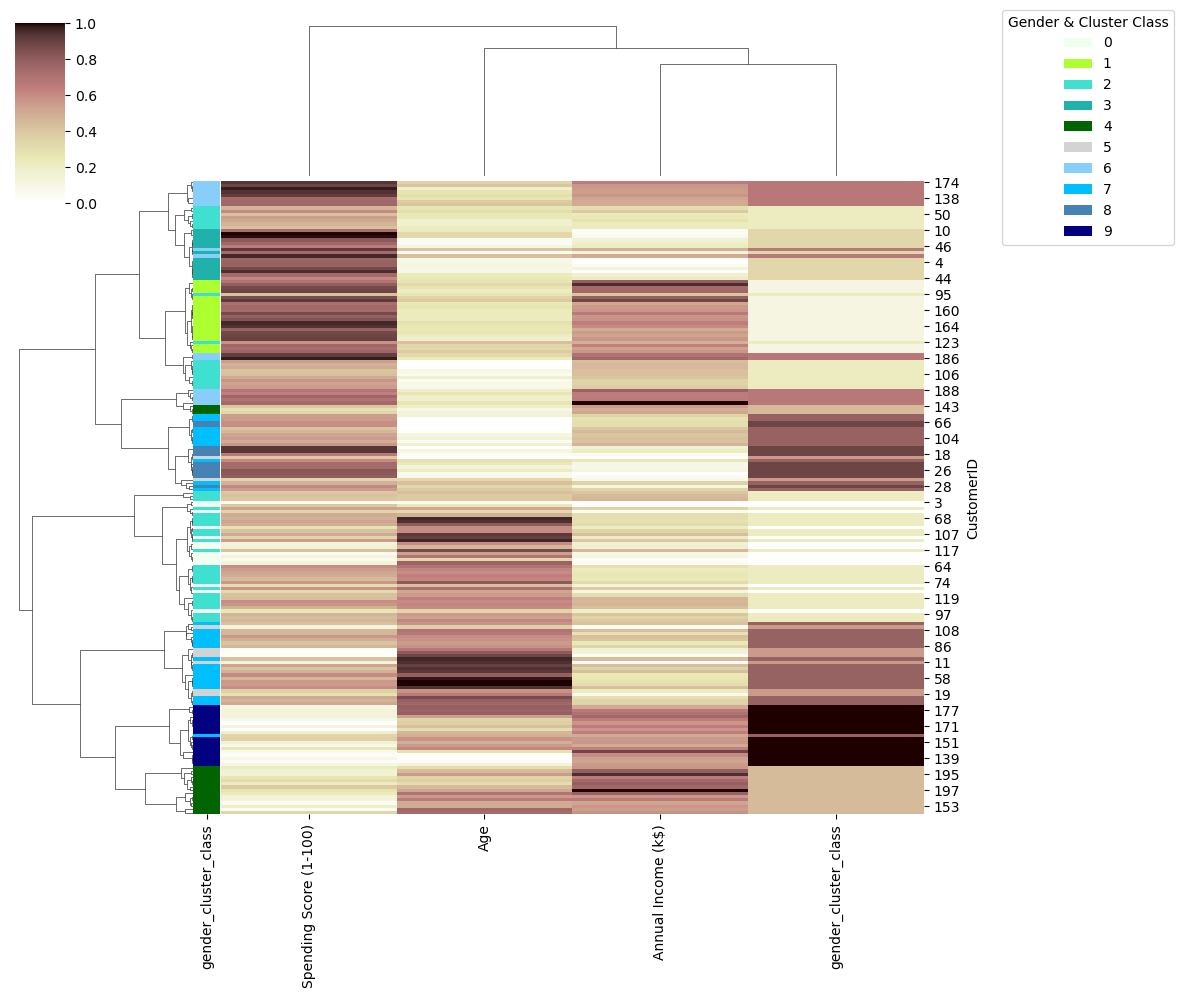

In [43]:
# For more information about clustermap: http://seaborn.pydata.org/generated/seaborn.clustermap.html
# Choose your favorite color from here :) :https://matplotlib.org/stable/gallery/color/named_colors.html
from matplotlib.patches import Patch

# Specify row color palette
my_palette=dict(zip(sorted(cmap_df["gender_cluster_class"].unique()), 
                    ["honeydew", "greenyellow", "turquoise", "lightseagreen", "darkgreen", 
                     "lightgrey", "lightskyblue", "deepskyblue", "steelblue", "navy"]))
row_colors = cmap_df["gender_cluster_class"].map(my_palette)

# Create clustermap plot
sns.clustermap(cmap_df, metric="correlation", cmap="pink_r",
               standard_scale=1, row_colors=row_colors)

# Add extra legend to reflect meaning of row color palette
handles = [Patch(facecolor=my_palette[name]) for name in my_palette]
plt.legend(handles, my_palette, title='Gender & Cluster Class',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper left')

plt.show()